In [1]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

torch.cuda.device_count()
torch.cuda.get_device_name(0), torch.cuda.get_device_name(1)

('GeForce GTX 1080', 'GeForce GTX 1080')

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # several transform objects are combined.

# tranforms.ToTensor   -> transforms a PIL image or numpy ndarry to Tensor
# transforms.Normalize -> class torchvision.transforms.Normalize(mean, std)
# Normalize a tensor image with mean and standard deviation. Given mean: (M1,...,Mn) and std: (S1,..,Sn) for n channels,
# this transform will normalize each channel of the input torch.*Tensor i.e. input[channel] = (input[channel] - mean[channel]) / std[channel]

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



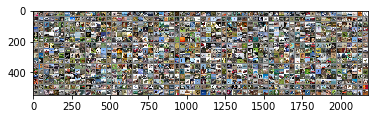

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images, 64)) # 64 pictures a row
# print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
# send network to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # Loss functions are in torch.nn
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [7]:
trainloader

In [8]:
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): # generate [(i, (image, label)),...], (image, label) is a tensor pair, size is of batch size
        # get the inputs
        inputs, labels = data
        
        # send to gpu:
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() # (update weight)

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 0.012
[1,    20] loss: 0.012
[1,    30] loss: 0.012
[1,    40] loss: 0.012
[2,    10] loss: 0.012
[2,    20] loss: 0.012
[2,    30] loss: 0.012
[2,    40] loss: 0.012
[3,    10] loss: 0.012
[3,    20] loss: 0.012
[3,    30] loss: 0.012
[3,    40] loss: 0.012
[4,    10] loss: 0.012
[4,    20] loss: 0.012
[4,    30] loss: 0.012
[4,    40] loss: 0.012
[5,    10] loss: 0.012
[5,    20] loss: 0.012
[5,    30] loss: 0.012
[5,    40] loss: 0.012
[6,    10] loss: 0.012
[6,    20] loss: 0.012
[6,    30] loss: 0.012
[6,    40] loss: 0.012
[7,    10] loss: 0.012
[7,    20] loss: 0.012
[7,    30] loss: 0.011
[7,    40] loss: 0.011
[8,    10] loss: 0.011
[8,    20] loss: 0.011
[8,    30] loss: 0.011
[8,    40] loss: 0.011
[9,    10] loss: 0.011
[9,    20] loss: 0.011
[9,    30] loss: 0.011
[9,    40] loss: 0.011
[10,    10] loss: 0.011
[10,    20] loss: 0.011
[10,    30] loss: 0.011
[10,    40] loss: 0.011
[11,    10] loss: 0.011
[11,    20] loss: 0.011
[11,    30] loss: 0.011
[11,

[86,    40] loss: 0.008
[87,    10] loss: 0.007
[87,    20] loss: 0.007
[87,    30] loss: 0.007
[87,    40] loss: 0.008
[88,    10] loss: 0.007
[88,    20] loss: 0.007
[88,    30] loss: 0.007
[88,    40] loss: 0.007
[89,    10] loss: 0.007
[89,    20] loss: 0.007
[89,    30] loss: 0.007
[89,    40] loss: 0.007
[90,    10] loss: 0.007
[90,    20] loss: 0.007
[90,    30] loss: 0.007
[90,    40] loss: 0.007
[91,    10] loss: 0.007
[91,    20] loss: 0.007
[91,    30] loss: 0.007
[91,    40] loss: 0.007
[92,    10] loss: 0.007
[92,    20] loss: 0.007
[92,    30] loss: 0.007
[92,    40] loss: 0.007
[93,    10] loss: 0.007
[93,    20] loss: 0.007
[93,    30] loss: 0.007
[93,    40] loss: 0.007
[94,    10] loss: 0.007
[94,    20] loss: 0.007
[94,    30] loss: 0.007
[94,    40] loss: 0.007
[95,    10] loss: 0.007
[95,    20] loss: 0.007
[95,    30] loss: 0.007
[95,    40] loss: 0.007
[96,    10] loss: 0.007
[96,    20] loss: 0.007
[96,    30] loss: 0.007
[96,    40] loss: 0.007
[97,    10] loss

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog  deer   dog truck  bird  deer   car truck   dog  deer  frog   dog  frog plane truck   cat truck horse  frog truck  ship plane   cat  ship  ship horse horse  deer  frog horse   cat  frog   cat  frog  bird   car  bird   cat horse  bird  frog  ship  ship plane  bird truck   cat   cat  ship  ship   car   car horse  bird   dog  bird horse  ship truck plane   cat  ship  frog  deer  frog  frog plane plane horse  deer   dog  frog   cat   car   car   cat  frog  ship horse  deer plane  frog  bird   car   cat plane  deer  bird horse  ship   cat   car  bird  ship plane  ship   cat   dog  bird  deer   car  ship truck   car  bird truck horse  bird truck  frog   dog  frog   cat  ship horse  frog  bird   dog  bird  ship truck  frog plane plane   dog  bird truck   dog  deer  bird   car  frog  frog  s

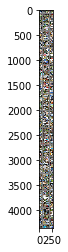

In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()
# move to gpu:
images, labels = images.to(device), labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images.cpu())) # use Tensor.cpu() to copy the tensor to host memory first.
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(1024)))

Okay, now let us see what the neural network thinks these examples above are:



In [10]:
outputs = net(images)
print(outputs)

tensor([[-1.7173, -1.5189,  0.7485,  ..., -1.6805, -1.5345, -1.1872],
        [ 4.2766,  3.8346, -1.3362,  ..., -4.6497,  7.0011,  2.4526],
        [ 1.7734,  2.3163, -0.8041,  ..., -1.6991,  3.7695,  2.1591],
        ...,
        [-0.3857, -0.6644,  1.0475,  ..., -1.8414,  0.0345, -2.1962],
        [ 3.6190,  0.7286,  0.9362,  ..., -1.7793,  2.4592,  0.0014],
        [ 4.6758,  2.1556,  1.3961,  ..., -3.1505,  2.9263,  1.6998]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [11]:
torch.max(outputs, 1)

(tensor([1.9488, 7.0011, 3.7695,  ..., 1.9112, 3.6190, 4.6758],
        device='cuda:0', grad_fn=<MaxBackward0>),
 tensor([3, 8, 8,  ..., 6, 0, 0], device='cuda:0'))

In [12]:
_, predicted = torch.max(outputs, 1) # doc for torch.max: https://pytorch.org/docs/stable/torch.html?highlight=torch%20max#torch.max

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(1024)))

Predicted:    cat  ship  ship  ship  frog  frog   car  frog   dog   car plane   car  frog horse   car  ship   dog   cat  ship  frog horse plane plane truck  deer  frog  frog  deer truck  frog  frog  bird  deer  frog truck   dog  frog   car   car   dog truck  frog   dog  frog plane truck   cat horse  deer  frog truck  ship  frog   cat  ship  ship   dog   car horse  deer  deer   cat   car   car  frog  frog   car plane   cat truck  deer  frog  ship  ship  ship  bird truck   cat   cat  ship  ship   car  bird   dog  bird horse   cat  ship  ship   car  ship  deer  ship  frog  deer   dog  frog plane   dog truck  deer horse  frog   cat   car  ship  frog  frog   dog   dog   dog plane  bird  bird truck  deer plane   dog  bird   dog  ship  deer  bird  bird plane  frog plane   dog   cat  bird  deer truck truck truck   car   dog truck plane  frog  ship  deer   dog   cat   dog  ship  bird  frog   dog   dog   cat  ship truck   cat  ship  bird  frog  bird  ship   cat  deer  bird   car truck  frog  shi

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 48 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [14]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(8):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 25 %
Accuracy of   car : 60 %
Accuracy of  bird : 25 %
Accuracy of   cat : 25 %
Accuracy of  deer : 40 %
Accuracy of   dog : 60 %
Accuracy of  frog : 60 %
Accuracy of horse : 50 %
Accuracy of  ship : 83 %
Accuracy of truck : 50 %


Okay, so what next?

How do we run these neural networks on the GPU?

Training on GPU
----------------
Just like how you transfer a Tensor on to the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cuda:0


The rest of this section assumes that `device` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = inputs.to(device), labels.to(device)

Why dont I notice MASSIVE speedup compared to CPU? Because your network
is realllly small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

Training on multiple GPUs
-------------------------
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.

Where do I go next?
-------------------

-  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_
-  `Chat with other users on Slack`_


